# **Task 2 - Heart Failure Analysis**


*Project by Alix CHARPENTIER and Clothilde DUGROS*

**Context** :
A renowned hospital's cardiology department is conducting a study to pinpoint factors that can foretell deadly heart failure. By doing so, the department will be better prepared to identify patients at risk and provide them with adequate care. [Guidelines here](https://smellydatascience.com/teaching/python-for-data-science/evaluation)


> *We provide the analysis of the results in the report*




# Introduction, Data and Methodology

In [54]:
!pip install lifelines
from lifelines import KaplanMeierFitter
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns # visualisation
import pandas as pd
import numpy as np
import statsmodels.api as sm # logit regression
from sklearn import neighbors # knn
from sklearn import model_selection # knn
from sklearn import metrics # knn

### a. Cleaning the dataset

In [ ]:
data = pd.read_csv("/heart_failure.csv", sep=",") # put your file location

In [ ]:
data.head(10) # first five observations to look at the dataset

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1,10,1


In [ ]:
print("There are {rows} observations and {columns} variables.".format(rows=data.shape[0], columns = data.shape[1])) # tuple

There are 299 observations and 13 variables.


In [ ]:
data.info() # to check the types of the variables,  the number of non-null observations per variable and the memory usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [ ]:
# age recoding
data["age"] = data["age"].astype("int8")
print("The type of the age variable is now {types}.".format(types = data.dtypes.age))

The type of the age variable is now int8.


In [ ]:
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values) # no missing values

Missing values in each column:
 age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


In [ ]:
duplicate_rows = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}") # no duplicates

Number of duplicate rows: 0


In [ ]:
# descriptive statistics
stat_desc = data.describe() # only for numerical variables
print(stat_desc)

              age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.829431    0.431438                581.839465    0.418060   
std     11.894997    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           299.000000     299.000000   
mean           38.083612             0.351171  263358.029264   
std            11.834841             0.478136   97804.236869   
min            14.000000             0.000000   25100.000000   
25%            30.000000             0.0

### Setting up variables

In [ ]:
# age categories (quartiles)
q1_age = int(np.percentile(data.age, 25))
q2_age = int(np.percentile(data.age, 50))
q3_age = int(np.percentile(data.age, 75))

# The function np.percentile outputs a float54. For lisibility, we add a int() function.

print("The quartiles of the age variable are: {q1} (Q1), {q2} (Q2) and {q3} (Q3). ".format(q1 = q1_age, q2 = q2_age, q3 = q3_age))

# Define the labels for each quartile
labels = ['middle-aged', 'old', 'very old']

# Use pd.qcut to categorize the age variable into quartiles and assign labels
data['age_quartile'] = pd.qcut(data['age'], q=[0, 0.25, 0.75, 1.0], labels=labels)

# Check the results
print(data[['age', 'age_quartile']].head())

The quartiles of the age variable are: 51 (Q1), 60 (Q2) and 70 (Q3). 
   age age_quartile
0   75     very old
1   55          old
2   65          old
3   50  middle-aged
4   65          old


In [ ]:
# Ejection fraction categories (quartiles)
q1_EF = int(np.percentile(data.ejection_fraction, 25))
q2_EF = int(np.percentile(data.ejection_fraction, 50))
q3_EF = int(np.percentile(data.ejection_fraction, 75))
print("The quartiles of the ejection_fraction variable are: {q1} (Q1), {q2} (Q2) and {q3} (Q3). ".format(q1 = q1_EF, q2 = q2_EF, q3 = q3_EF))

# Define the labels for each quartile
labels = ['low', 'medium', 'high']

# Use pd.qcut to categorize the ejection_fraction variable into quartiles and assign labels
data['EF_quartile'] = pd.qcut(data['ejection_fraction'], q=[0, 0.25, 0.75, 1.0], labels=labels)

# Check the results
print(data[['ejection_fraction', 'EF_quartile']].head())

The quartiles of the ejection_fraction variable are: 30 (Q1), 38 (Q2) and 45 (Q3). 
   ejection_fraction EF_quartile
0                 20         low
1                 38      medium
2                 20         low
3                 20         low
4                 20         low


In [ ]:
# platelets categories (quartiles)
q1_platelets = np.percentile(data.platelets, 25)
q2_platelets = np.percentile(data.platelets, 50)
q3_platelets = np.percentile(data.platelets, 75)
print("The quartiles of the platelets variable are: {q1} (Q1), {q2} (Q2) and {q3} (Q3). ".format(q1 = q1_platelets, q2 = q2_platelets, q3 = q3_platelets))

# Define labels for each quartile
labels = ['low', 'medium', 'high']

# Use pd.qcut to categorize the platelets variable into quartiles and assign labels
data['platelets_quartile'] = pd.qcut(data['platelets'], q=[0, 0.25, 0.75, 1.0], labels=labels)

# Check the results
print(data[['platelets', 'platelets_quartile']].head())

The quartiles of the platelets variable are: 212500.0 (Q1), 262000.0 (Q2) and 303500.0 (Q3). 
   platelets platelets_quartile
0  265000.00             medium
1  263358.03             medium
2  162000.00                low
3  210000.00                low
4  327000.00               high


# 1) **Charting the Patient Landscape**

### a. Means Table

In [ ]:
# splitting the data into the dead and censored groups
dead_patients = data[data['DEATH_EVENT'] == 1]
censored_patients = data[data['DEATH_EVENT'] == 0]

# continuous variables: Calculate means for dead and censored groups
summary_continuous = pd.DataFrame({
    'Variable': ['Creatinine', 'Sodium', 'CPK', 'Age', 'Platelets', 'EF'],
    'Dead (96)': [
        dead_patients['serum_creatinine'].mean(),
        dead_patients['serum_sodium'].mean(),
        dead_patients['creatinine_phosphokinase'].mean(),
        dead_patients['age'].mean(),
        dead_patients['platelets'].mean(),
        dead_patients['ejection_fraction'].mean()],
    'Censored (203)': [
        censored_patients['serum_creatinine'].mean(),
        censored_patients['serum_sodium'].mean(),
        censored_patients['creatinine_phosphokinase'].mean(),
        censored_patients['age'].mean(),
        censored_patients['platelets'].mean(),
        censored_patients['ejection_fraction'].mean()]
})

# categorical variables: Calculate counts and percentages for dead and censored groups
summary_categorical = pd.DataFrame({
    'Variable': ['Male', 'Smoking', 'Diabetes', 'BP', 'Anemia'],
    'Dead (96)': [
        f"{dead_patients['sex'].sum()} ({dead_patients['sex'].mean() * 100:.0f}%)",
        f"{dead_patients['smoking'].sum()} ({dead_patients['smoking'].mean() * 100:.0f}%)",
        f"{dead_patients['diabetes'].sum()} ({dead_patients['diabetes'].mean() * 100:.0f}%)",
        f"{dead_patients['high_blood_pressure'].sum()} ({dead_patients['high_blood_pressure'].mean() * 100:.0f}%)",
        f"{dead_patients['anaemia'].sum()} ({dead_patients['anaemia'].mean() * 100:.0f}%)"],
    'Censored (203)': [
        f"{censored_patients['sex'].sum()} ({censored_patients['sex'].mean() * 100:.0f}%)",
        f"{censored_patients['smoking'].sum()} ({censored_patients['smoking'].mean() * 100:.0f}%)",
        f"{censored_patients['diabetes'].sum()} ({censored_patients['diabetes'].mean() * 100:.0f}%)",
        f"{censored_patients['high_blood_pressure'].sum()} ({censored_patients['high_blood_pressure'].mean() * 100:.0f}%)",
        f"{censored_patients['anaemia'].sum()} ({censored_patients['anaemia'].mean() * 100:.0f}%)"]
})

table_1 = pd.concat(
    [summary_continuous, summary_categorical],
    keys=['Continuous Variables', 'Categorical Variables']
)

from IPython.display import display
display(table_1)

Variable      Dead (96) Censored (203)
Continuous Variables  0  Creatinine       1.835833       1.184877
                      1      Sodium        135.375     137.216749
                      2         CPK     670.197917     540.054187
                      3         Age      65.208333      58.758621
                      4   Platelets  256381.044792  266657.489901
                      5          EF       33.46875       40.26601
Categorical Variables 0        Male       62 (65%)      132 (65%)
                      1     Smoking       30 (31%)       66 (33%)
                      2    Diabetes       40 (42%)       85 (42%)
                      3          BP       39 (41%)       66 (33%)
                      4      Anemia       46 (48%)       83 (41%)

#### i. Categorical Variables

In [ ]:
# make assumptions about the meaning of the dummy variables

anaemia_counts = data["anaemia"].value_counts() # to know the number of patients in each category
anameia_labels = {0: 'No Anaemia', 1: 'Anaemia'} # labels will be useful for the pie charts (see below)
anaemia_mapped_labels = anaemia_counts.index.map(anameia_labels) # links the label with the value (0 or 1)

diabetes_counts = data["diabetes"].value_counts()
diabetes_labels = {0: 'No diabetes', 1: 'Diabetes'}
diabetes_mapped_labels = diabetes_counts.index.map(diabetes_labels)

blood_pressure_counts = data["high_blood_pressure"].value_counts()
blood_labels = {0: 'Low blood pressure', 1: 'High blood pressure'}
blood_mapped_labels = diabetes_counts.index.map(blood_labels)

smoking_counts = data["smoking"].value_counts()
smoking_labels = {0: 'No smoking', 1: 'Smoking'}
smoking_mapped_labels = diabetes_counts.index.map(smoking_labels)

sex_counts = data["sex"].value_counts()
sex_labels = {0: 'Women', 1: 'Men'}
sex_mapped_labels = sex_counts.index.map(sex_labels)

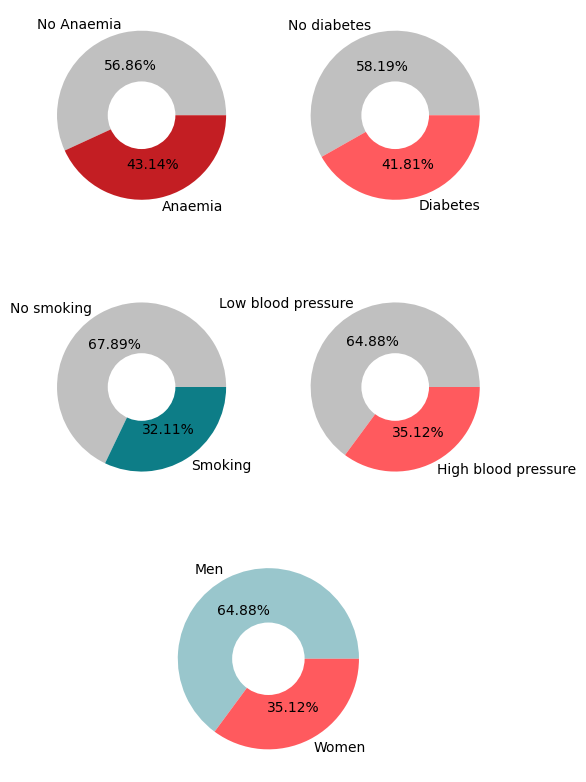

In [ ]:
fig1 = plt.figure(figsize = (6,10)) # defines the size of the figure
grid= fig1.add_gridspec(3, 2) # creates a grid in which we are going to position the graphs

plt.subplot(grid[0, 0]) # 1st square of the grid
plt.pie(x= anaemia_counts,
    labels=anaemia_mapped_labels,
    autopct='%.2f%%', # string formatting (percentage and 2 decimals)
    colors=['#c0c0c0', '#c31e23'])
hole = plt.Circle((0, 0), 0.4, facecolor='white') # create a donut chart
plt.gcf().gca().add_artist(hole)

plt.subplot(grid[0, 1])
plt.pie(x= diabetes_counts,
    labels=diabetes_mapped_labels,
    autopct='%.2f%%',
    colors=['#c0c0c0', '#ff5a5e'])
hole = plt.Circle((0, 0), 0.4, facecolor='white')
plt.gcf().gca().add_artist(hole)

plt.subplot(grid[1, 0])
plt.pie(x= smoking_counts,
    labels=smoking_mapped_labels,
    autopct='%.2f%%',
    colors=['#c0c0c0', '#0d7d87'])
hole = plt.Circle((0, 0), 0.4, facecolor='white')
plt.gcf().gca().add_artist(hole)


plt.subplot(grid[1, 1])
plt.pie(x= blood_pressure_counts,
    labels=blood_mapped_labels,
    autopct='%.2f%%',
    colors=['#c0c0c0', '#ff5a5e'])
hole = plt.Circle((0, 0), 0.4, facecolor='white')
plt.gcf().gca().add_artist(hole)

plt.subplot(grid[2, :])
plt.pie(
    x= sex_counts,
    labels=sex_mapped_labels,
    autopct='%.2f%%',
    colors=['#99c6cc', '#ff5a5e'])
hole = plt.Circle((0, 0), 0.4, facecolor='white')
plt.gcf().gca().add_artist(hole)

plt.show()

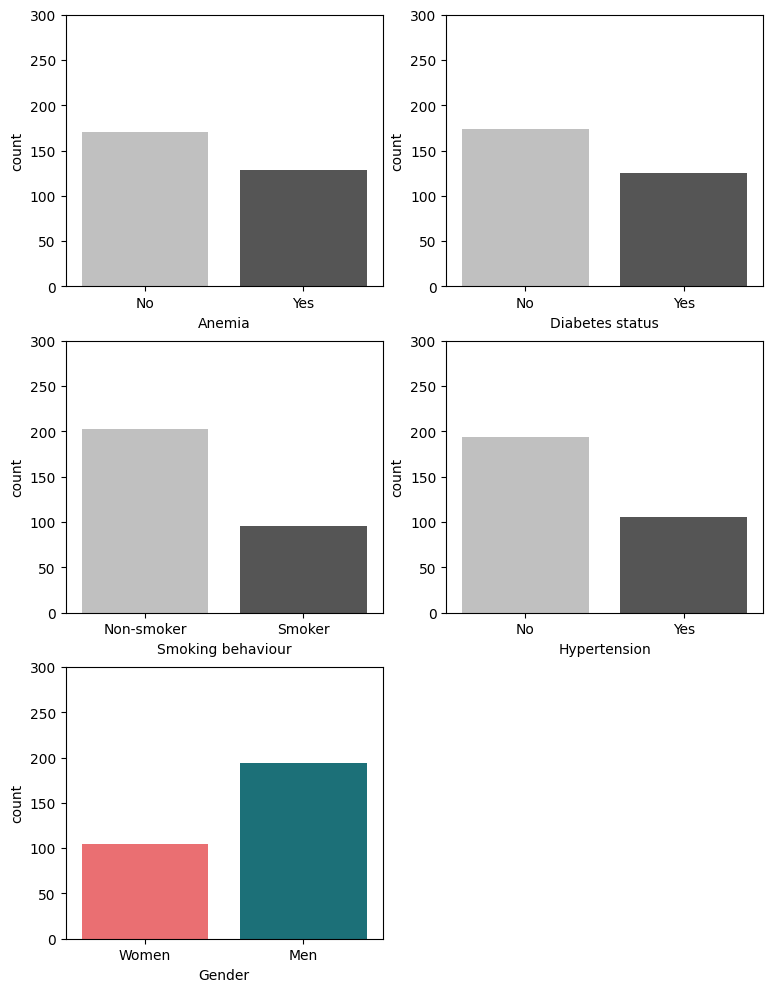

In [ ]:
fig2 = plt.figure(figsize = (9,12)) # size of the figure
grid= fig2.add_gridspec(3,2) # grid

ax1 = fig2.add_subplot(grid[0, 0])
sns.countplot(
    data=data,
    x="anaemia",
    hue="anaemia",
    palette={0: '#c0c0c0', 1: '#555555'},
    stat = "count",
    legend=False
)
ax1.set(
  #title="Number of patients that have anemia",
  xlabel="Anemia"
)
ax1.set_xticks(ticks=[0, 1], labels=['No', 'Yes'])
ax1.set_ylim(0, 300)

ax2 = fig2.add_subplot(grid[0, 1])
sns.countplot(
    data=data,
    x="diabetes",
    hue="diabetes",
    palette={0: '#c0c0c0', 1: '#555555'},
    stat = "count",
    legend=False
)
ax2.set(
  #title="Number of patients that have diabetes",
  xlabel="Diabetes status",
)
ax2.set_xticks(ticks=[0, 1], labels=['No', 'Yes'])
ax2.set_ylim(0, 300)

ax3 = fig2.add_subplot(grid[1,0])
sns.countplot(
    data=data,
    x="smoking",
    hue="smoking",
    palette={0: '#c0c0c0', 1: '#555555'},
    stat = "count",
    legend=False
)
ax3.set(
  #title="Number of patients that smoke",
  xlabel="Smoking behaviour",
)
ax3.set_xticks(ticks=[0, 1], labels=['Non-smoker', 'Smoker'])
ax3.set_ylim(0, 300)

ax4 = fig2.add_subplot(grid[1,1])
sns.countplot(
    data=data,
    x="high_blood_pressure",
    hue="high_blood_pressure",
    palette={0: '#c0c0c0', 1: '#555555'},
    stat ="count",
    legend=False
)
ax4.set(
  #title="Number of patients that have hypertension",
  xlabel="Hypertension",
)
ax4.set_xticks(ticks=[0,1], labels=['No', 'Yes'])
ax4.set_ylim(0, 300)

ax5 = fig2.add_subplot(grid[2,0])
sns.countplot(
    data=data,
    x="sex",
    hue="sex",
    palette={0:'#ff5a5e' , 1: '#0d7d87'},
    stat = "count",
    legend=False
)
ax5.set(
  #title="Number of patients according to their gender",
  xlabel="Gender",
)
ax5.set_xticks(ticks=[0, 1], labels=['Women', 'Men'])
ax5.set_ylim(0, 300)

#plt.savefig('dist_cat_var.png', bbox_inches='tight')
plt.show()

#### ii. Continuous Variables

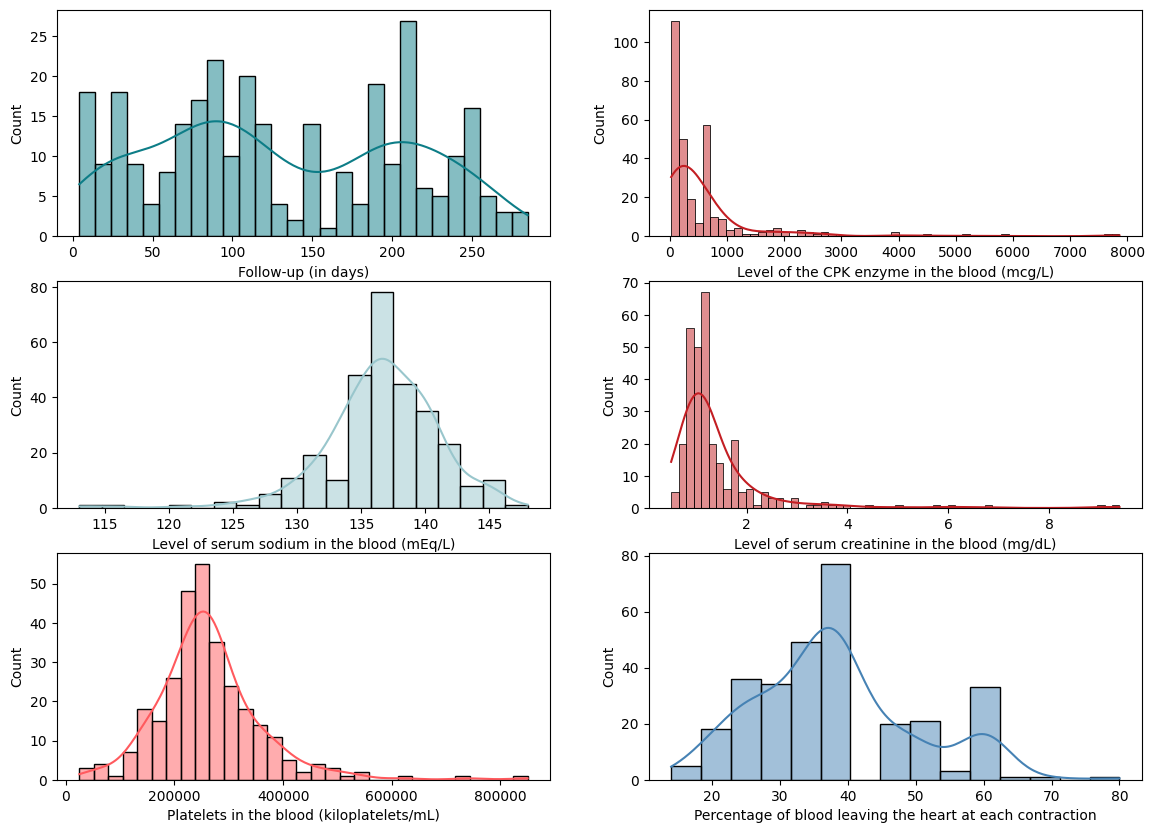

In [ ]:
fig3 = plt.figure(figsize = (14,10)) # size of the figure
grid2= fig3.add_gridspec(3, 2) # grid

plt.subplot(grid2[0, 0])
sns.histplot(data=data, # histogram
            x='time',
            kde=True,
            binwidth=10, # 10-day bins
            color="#0d7d87",
            edgecolor="black").set(xlabel='Follow-up (in days)')

plt.subplot(grid2[0, 1])
sns.histplot(data=data,
            x='creatinine_phosphokinase',
            kde=True,
            color="#c31e23",
            edgecolor="black").set(xlabel='Level of the CPK enzyme in the blood (mcg/L)')

plt.subplot(grid2[1, 0])
sns.histplot(data=data,
            x='serum_sodium',
            kde=True,
            color="#99c6cc",
            edgecolor="black").set(xlabel='Level of serum sodium in the blood (mEq/L)')

plt.subplot(grid2[1, 1])
sns.histplot(data=data,
            x='serum_creatinine',
            kde=True,
            color="#c31e23",
            edgecolor="black").set(xlabel='Level of serum creatinine in the blood (mg/dL)')

plt.subplot(grid2[2, 0])
sns.histplot(data=data,
            x='platelets',
            kde=True,
            color="#ff5a5e",
            edgecolor="black").set(xlabel='Platelets in the blood (kiloplatelets/mL)')

plt.subplot(grid2[2, 1])
sns.histplot(data=data,
            x='ejection_fraction',
             kde=True,
            color="steelblue",
            edgecolor="black").set(xlabel='Percentage of blood leaving the heart at each contraction')
#plt.savefig('dist_cont_his.png', bbox_inches='tight')
plt.show()

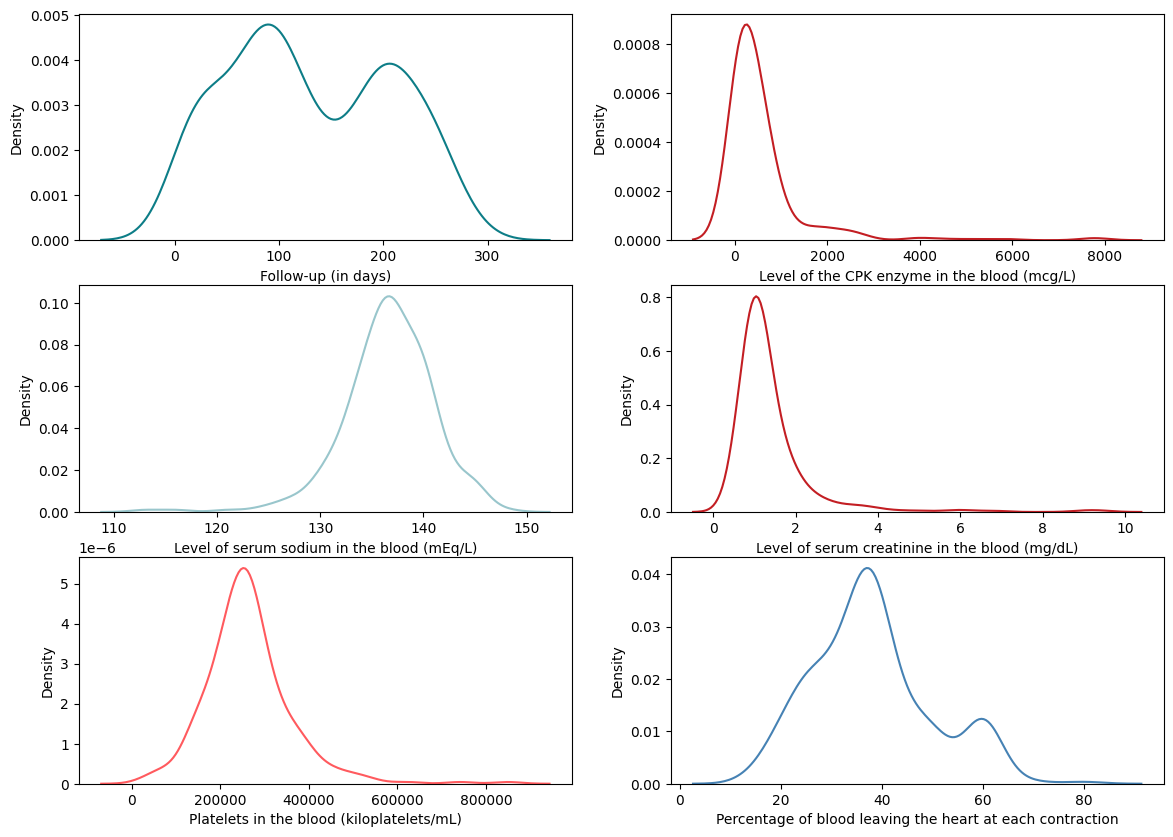

In [ ]:
fig3 = plt.figure(figsize = (14,10)) # size of the figure
grid3= fig2.add_gridspec(3, 2) # grid

plt.subplot(grid3[0, 0])
sns.kdeplot(data=data, # density plots
            x='time',
            color="#0d7d87").set(xlabel='Follow-up (in days)')

plt.subplot(grid3[0, 1])
sns.kdeplot(data=data,
            x='creatinine_phosphokinase',
            color="#c31e23").set(xlabel='Level of the CPK enzyme in the blood (mcg/L)')

plt.subplot(grid3[1, 0])
sns.kdeplot(data=data,
            x='serum_sodium',
            color="#99c6cc").set(xlabel='Level of serum sodium in the blood (mEq/L)')

plt.subplot(grid3[1, 1])
sns.kdeplot(data=data,
            x='serum_creatinine',
            color="#c31e23").set(xlabel='Level of serum creatinine in the blood (mg/dL)')

plt.subplot(grid3[2, 0])
sns.kdeplot(data=data,
            x='platelets',
            color="#ff5a5e").set(xlabel='Platelets in the blood (kiloplatelets/mL)')

plt.subplot(grid3[2, 1])
sns.kdeplot(data=data,
            x='ejection_fraction',
            color="steelblue").set(xlabel='Percentage of blood leaving the heart at each contraction')
#plt.savefig('dist_cont_var_density.png', bbox_inches='tight')
plt.show()


In [ ]:
# look at the potential outliers
CPK = data.sort_values(["creatinine_phosphokinase"], ascending =[False])
CPK.head(5) # People with the highest (abnormal) CPK are dead, so they cannot be mistaken (someone alive with that level of CPK is unlikely).

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,age_quartile,EF_quartile,platelets_quartile
1,55,0,7861,0,38,0,263358.03,1.10,136,1,0,6,1,old,medium,medium
60,45,0,7702,1,25,1,390000.00,1.00,139,1,0,60,1,middle-aged,low,high
72,85,0,5882,0,35,0,243000.00,1.00,132,1,1,72,1,very old,medium,medium
103,42,0,5209,0,30,0,226000.00,1.00,140,1,1,87,0,middle-aged,low,medium
134,81,0,4540,0,35,0,231000.00,1.18,137,1,1,107,0,very old,medium,medium


In [ ]:
EF_outlier = data.sort_values(["ejection_fraction"], ascending =[True])
EF_outlier.head(10) # The lower the ejection fraction, the higher the risk of life-threatening complications, like cardiac arrest
# make sense with our data, people with the lower EF are often dead.

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,age_quartile,EF_quartile,platelets_quartile
17,45,0,582,0,14,0,166000.00,0.80,127,1,0,14,1,middle-aged,low,low
66,42,1,250,1,15,0,213000.00,1.30,136,0,0,65,1,middle-aged,low,medium
6,75,1,246,0,15,0,127000.00,1.20,137,1,0,10,1,very old,low,low
210,70,0,212,1,17,1,389000.00,1.00,136,1,1,188,0,old,low,high
126,46,0,168,1,17,1,271000.00,2.10,124,0,0,100,1,middle-aged,low,medium
167,59,0,66,1,20,0,70000.00,2.40,134,1,0,135,1,old,low,low
173,50,1,115,0,20,0,189000.00,0.80,139,1,0,146,0,middle-aged,low,low
74,69,0,582,0,20,0,266000.00,1.20,134,1,1,73,1,old,low,medium
40,70,0,582,0,20,1,263358.03,1.83,134,1,1,31,1,old,low,medium
48,80,1,553,0,20,1,140000.00,4.40,133,1,0,41,1,very old,low,low


## c. Correlations

- Corr plot

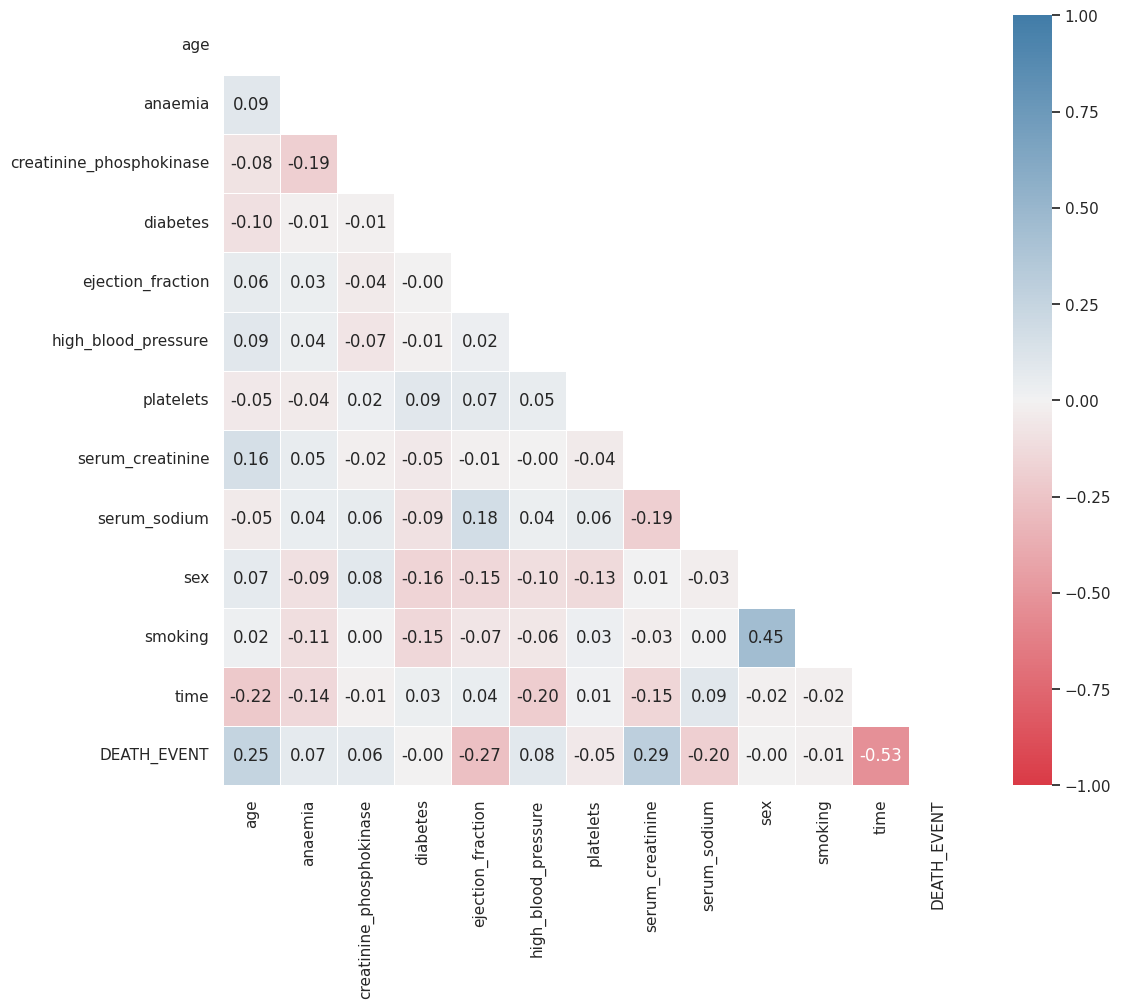

In [ ]:
#sns.set_theme(style="white")

data_corr = data.drop(columns=[ 'age_quartile', 'EF_quartile', 'platelets_quartile' ]) # suppress the variables we created

corr = data_corr.corr() # correlation matrix

plt.figure(figsize=(12, 10))

mask = np.triu(np.ones_like(corr, dtype=bool)) # mask for the upper triangle

cmap = sns.diverging_palette(10, 240, as_cmap=True)

sns.heatmap(corr,mask=mask, annot=True, cmap=cmap, fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

#plt.savefig('heatmap.png', bbox_inches='tight')
plt.show()

- Bar plots, Violins..

Is the smoker distribution the same for both genders?

In [ ]:
cross_tab_smoke_sex=100*pd.crosstab(data["sex"], data["smoking"], normalize="index", margins=True)
cross_tab_smoke_sex

smoking,0,1
sex,,
0,96.190476,3.809524
1,52.577320,47.422680
All,67.892977,32.107023


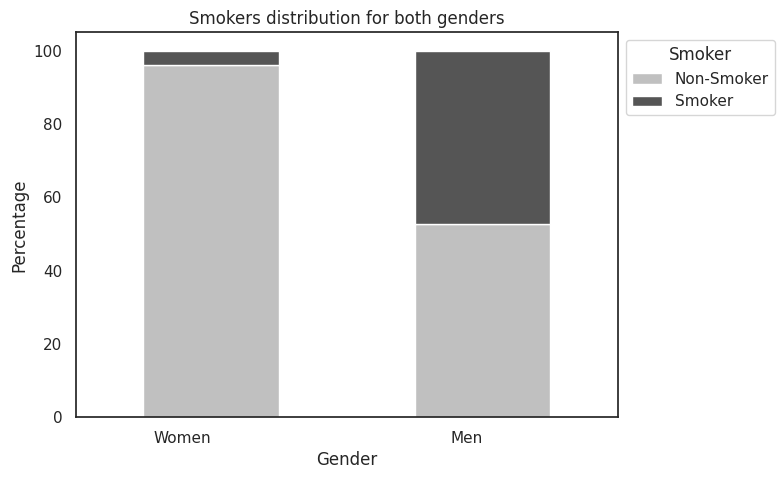

In [ ]:
cross_tab_smoke_sex=100*pd.crosstab(data["sex"], data["smoking"], normalize="index") # percentage
cross_tab_smoke_sex.columns = ["Non-Smoker", "Smoker"]
cross_tab_smoke_sex.plot(kind='bar', #bar plot
                    stacked=True, # stacked bar
                    color= ['#c0c0c0', '#555555'],
                    figsize=(7, 5))
plt.xticks(ticks=[0, 1], labels=['Women', 'Men'])
plt.legend(bbox_to_anchor=(1, 1),ncol=1, title="Smoker") # legend at the top-right corner
plt.xlabel("Gender")
plt.ylabel("Percentage")
plt.xticks(rotation=0, ha='right')
plt.title("Smokers distribution for both genders")
#plt.savefig('smoking_gender.png', bbox_inches='tight')
plt.show()

In [ ]:
cross_tab_diabetes_sex_all=100*pd.crosstab(data["sex"], data["diabetes"], normalize="index", margins=True)
cross_tab_diabetes_sex_all

diabetes,0,1
sex,,
0,47.619048,52.380952
1,63.917526,36.082474
All,58.193980,41.806020


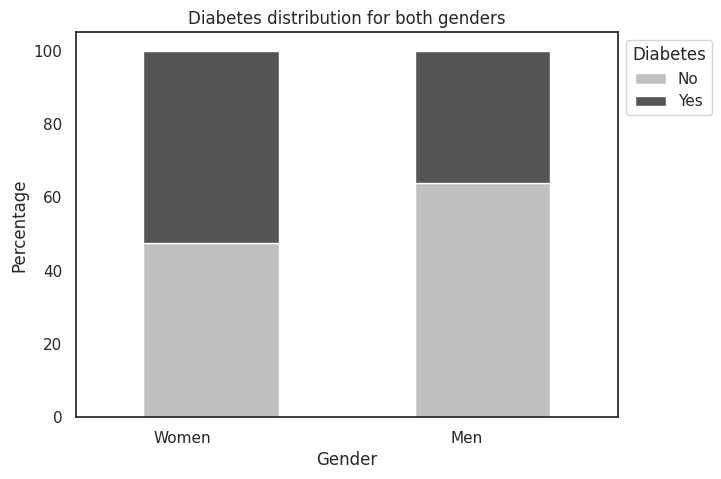

In [ ]:
cross_tab_diabetes_sex=100*pd.crosstab(data["sex"], data["diabetes"], normalize="index")
cross_tab_diabetes_sex.columns = ["No", "Yes"]
cross_tab_diabetes_sex.plot(kind='bar',
                    stacked=True,
                    color= ['#c0c0c0', '#555555'],
                    figsize=(7, 5))
plt.xticks(ticks=[0, 1], labels=['Women', 'Men'])
plt.legend(bbox_to_anchor=(1, 1),ncol=1, title="Diabetes")
plt.xlabel("Gender")
plt.ylabel("Percentage")
plt.xticks(rotation=0, ha='right')
plt.title("Diabetes distribution for both genders")
#plt.savefig('diabetes_gender.png', bbox_inches='tight')
plt.show()

Smoker and Age (violin)

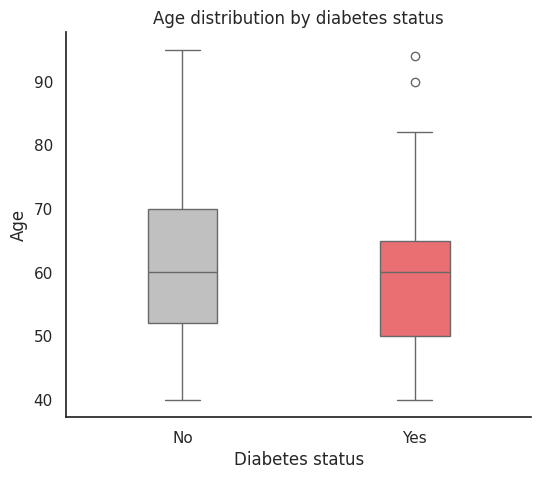

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.boxplot( # box plots
    data=data,
    x="diabetes",
    hue = "diabetes",
    y="age",
    legend = False,
    palette={0: '#c0c0c0', 1: '#ff5a5e'},
    width=.3
)

ax.set(
    title="Age distribution by diabetes status",
    xlabel="Diabetes status",
    ylabel="Age"
)
ax.set_xticks(ticks=[0, 1], labels=['No', 'Yes'])
#plt.savefig('diabetes_age.png')

sns.despine()

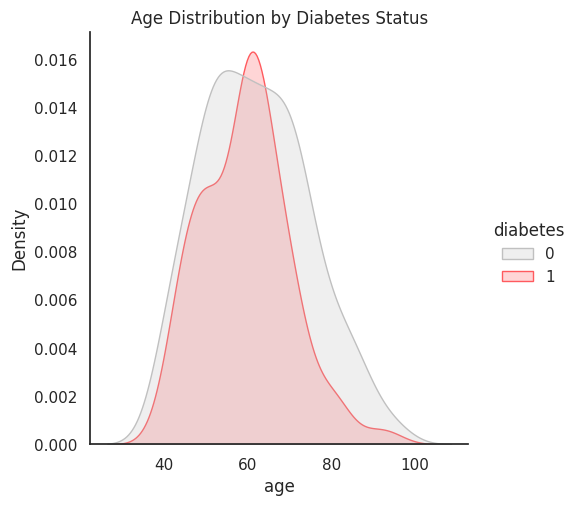

In [ ]:
density_plot = sns.displot(data, x="age", hue="diabetes", kind="kde", palette={0: '#c0c0c0', 1: '#ff5a5e'},fill=True).set(title='Age Distribution by Diabetes Status')
plt.show() # density plot

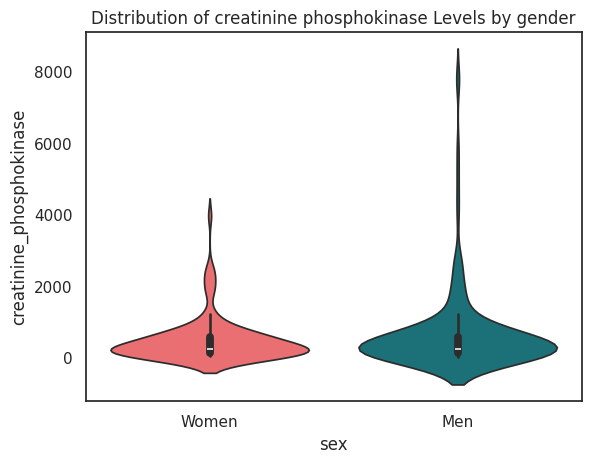

In [ ]:
violin = sns.violinplot( # violin plots
    data=data,
    x="sex",
    hue="sex",
    y="creatinine_phosphokinase",
    palette={0: "#ff5a5e", 1: "#0d7d87"}
)
violin.set(title='Distribution of creatinine phosphokinase Levels by gender')

violin.set_xticks(ticks=[0, 1], labels=['Women', 'Men'])
violin.get_legend().remove()

#plt.savefig('creat_gender.png', bbox_inches='tight')
plt.show()

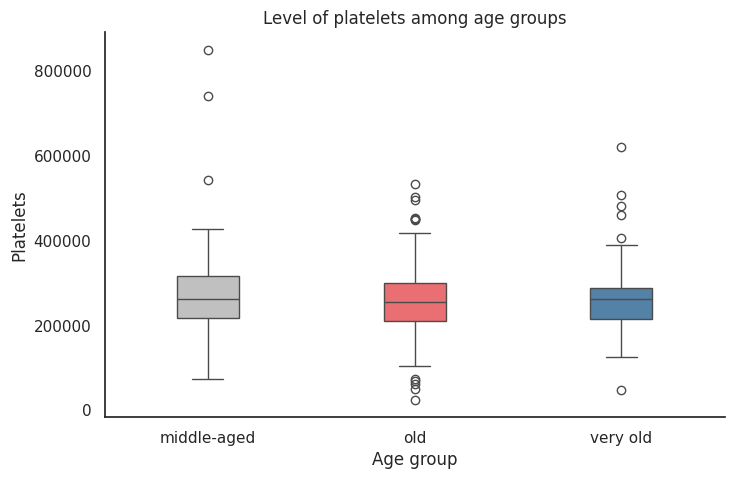

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.boxplot( # box plots
    data=data,
    x="age_quartile",
    hue = "age_quartile",
    y="platelets",
    legend = False,
    palette={"middle-aged": '#c0c0c0', "old": '#ff5a5e', "very old" :"steelblue"},
    width=.3
)

ax.set(
    title="Level of platelets among age groups",
    xlabel="Age group",
    ylabel="Platelets"
)
#plt.savefig('platelets_age.png')

sns.despine()

### e. Underlying Combinational Diseases with Upset Plot



  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=UpSetPlot-0.9.0-py3-none-any.whl size=24816 sha256=c340ac74104fc48cf7f1c74ca675d7d7e333ee01afe0e794457d86eb72281b5b
  Stored in directory: /root/.cache/pip/wheels/73/42/9f/1c9718ea27f30466d2787e0f7d88a7cb11942e3460c17e0ef6
Successfully built upsetplot


/usr/local/lib/python3.10/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.10/dist-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

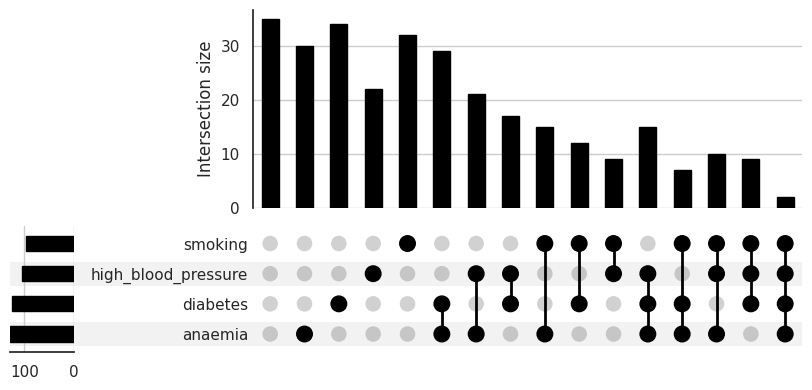

In [ ]:
!pip install upsetplot
from upsetplot import from_memberships, UpSet

## Prepare data for the upset plot
combinations = data.groupby(['smoking', 'anaemia', 'diabetes', 'high_blood_pressure']).size()

# Generate UpSet plot
upset = UpSet(combinations)
upset.plot()

# Show plot
plt.show()


# 2) **Mortality Rates and Survival Patterns with Heart Disease**


- Rates

In [ ]:
mortality_rate = (data.DEATH_EVENT.sum()/len(data.DEATH_EVENT))*100 # deceased people / total of patients
print("The mortality rate due to heart failure among the study's participants is {rate} percent.".format(rate=round(mortality_rate,2)))

The mortality rate due to heart failure among the study's participants is 32.11 percent.


**Sub-groups analysis **

In [ ]:
# By gender
cross_tab_sex_death = 100*pd.crosstab(data["sex"], data["DEATH_EVENT"],
                normalize="index", # computes percentages (convert to frequencies) within each category of gender
                margins=True) # sum on columns
cross_tab_sex_death

DEATH_EVENT,0,1
sex,,
0,67.619048,32.380952
1,68.041237,31.958763
All,67.892977,32.107023


In [ ]:
print("The mortality rates for women ({rate} %) and for men ({rate2} %) are quite similar.".format(rate=round(cross_tab_sex_death.loc[0, 1],2), rate2 = round(cross_tab_sex_death.loc[1,1],2)))

The mortality rates for women (32.38 %) and for men (31.96 %) are quite similar.


In [ ]:
# By smoking behaviour
cross_tab_smoke_death = 100*pd.crosstab(data["smoking"], data["DEATH_EVENT"],
                normalize="index") # percentage within each category of smoking status
cross_tab_smoke_death

DEATH_EVENT,0,1
smoking,,
0,67.487685,32.512315
1,68.750000,31.250000


In [ ]:
print("The mortality rates for smokers ({rate} %) and for non-smokers ({rate2} %) are quite similar.".format(rate=round(cross_tab_smoke_death.loc[1, 1],2), rate2 = round(cross_tab_smoke_death.loc[0,1],2)))

The mortality rates for smokers (31.25 %) and for non-smokers (32.51 %) are quite similar.


In [ ]:
# By diabates status
cross_tab_diabetes_death = 100*pd.crosstab(data["diabetes"], data["DEATH_EVENT"],
                normalize="index") # percentages within each category of diabetes status
cross_tab_diabetes_death

DEATH_EVENT,0,1
diabetes,,
0,67.816092,32.183908
1,68.000000,32.000000


In [ ]:
print("The mortality rates for people with diabetes ({rate} %) and for others ({rate2} %) are quite similar.".format(rate=round(cross_tab_diabetes_death.loc[1, 1],2), rate2 = round(cross_tab_diabetes_death.loc[0,1],2)))

The mortality rates for people with diabetes (32.0 %) and for others (32.18 %) are quite similar.


In [ ]:
# By blood pressure
cross_tab_blood_death = 100*pd.crosstab(data["high_blood_pressure"], data["DEATH_EVENT"],
                normalize="index") # 0 and 1 percentage in each category of blood pressure
cross_tab_blood_death

DEATH_EVENT,0,1
high_blood_pressure,,
0,70.618557,29.381443
1,62.857143,37.142857


In [ ]:
print("The mortality rate for people with hypertension ({rate} %) is higher than for others ({rate2} %).".format(rate=round(cross_tab_blood_death.loc[1, 1],2), rate2 = round(cross_tab_blood_death.loc[0,1],2)))

The mortality rate for people with hypertension (37.14 %) is higher than for others (29.38 %).


- Curves

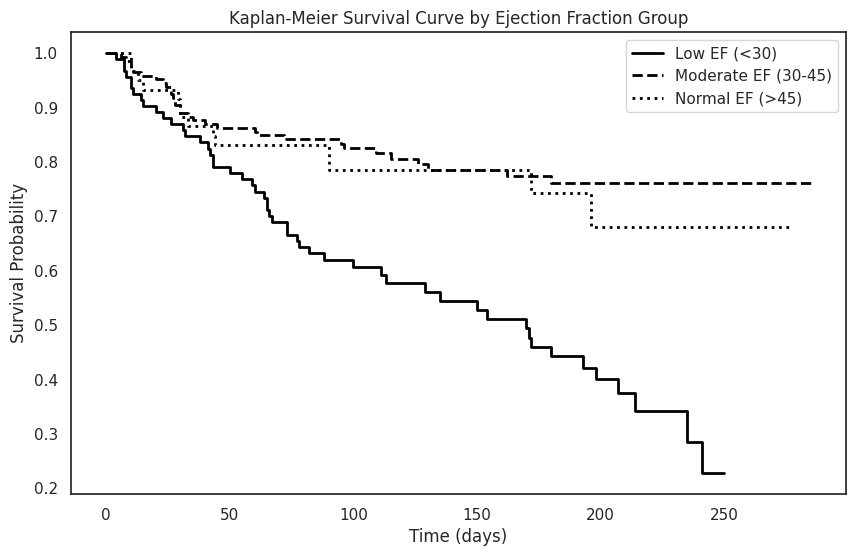

In [ ]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# low EF (<30)
mask_low_ef = (data['EF_quartile'] == 'low')
kmf.fit(data[mask_low_ef]['time'], event_observed=data[mask_low_ef]['DEATH_EVENT'], label='Low EF (<30)')
kmf.plot_survival_function(linestyle='-', linewidth=2, color='black', ci_show=False)

# moderate EF (30-45)
mask_moderate_ef = (data['EF_quartile'] == 'medium')
kmf.fit(data[mask_moderate_ef]['time'], event_observed=data[mask_moderate_ef]['DEATH_EVENT'], label='Moderate EF (30-45)')
kmf.plot_survival_function(linestyle='--', linewidth=2, color='black', ci_show=False)

#  normal EF (>45)
mask_normal_ef = (data['EF_quartile'] == 'high')
kmf.fit(data[mask_normal_ef]['time'], event_observed=data[mask_normal_ef]['DEATH_EVENT'], label='Normal EF (>45)')
kmf.plot_survival_function(linestyle=':', linewidth=2, color='black', ci_show=False)

plt.title('Kaplan-Meier Survival Curve by Ejection Fraction Group')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

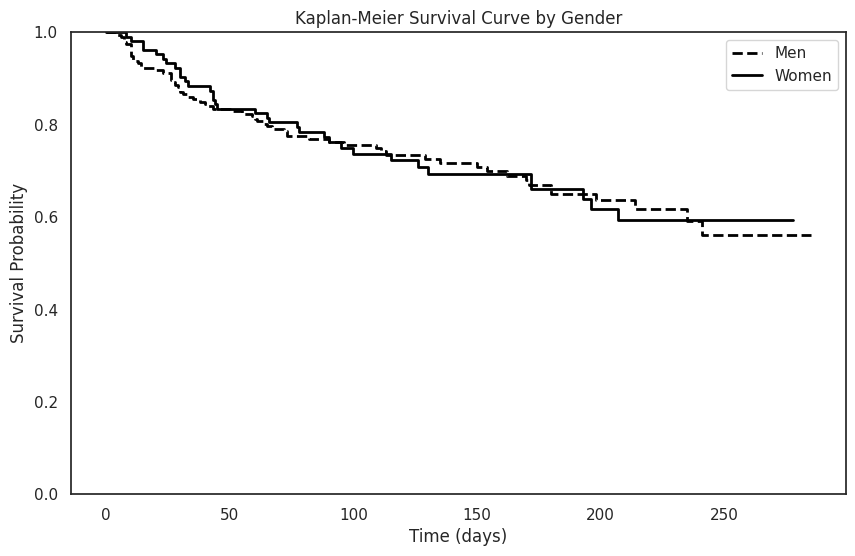

In [ ]:
# plot for male
plt.figure(figsize=(10, 6))

mask_male = (data['sex'] == 1)
kmf.fit(data[mask_male]['time'], event_observed=data[mask_male]['DEATH_EVENT'], label='Men')
kmf.plot_survival_function(linestyle='--', linewidth=2, color='black', ci_show=False)

# Plot for female
mask_female = (data['sex'] == 0)
kmf.fit(data[mask_female]['time'], event_observed=data[mask_female]['DEATH_EVENT'], label='Women')
kmf.plot_survival_function(linestyle='-', linewidth=2, color='black', ci_show=False)

plt.ylim(0, 1)

plt.title('Kaplan-Meier Survival Curve by Gender')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

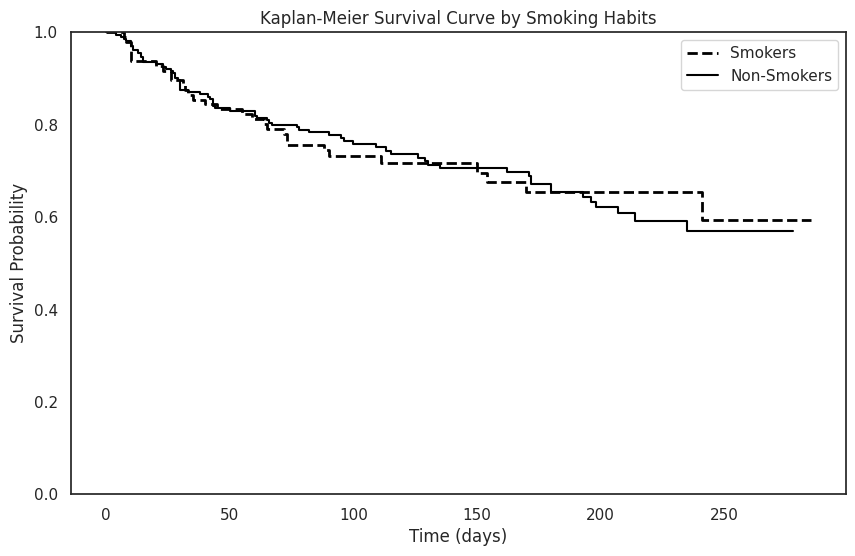

In [ ]:
plt.figure(figsize=(10, 6))

mask_smoker = (data['smoking'] == 1)
kmf.fit(data[mask_smoker]['time'], event_observed=data[mask_smoker]['DEATH_EVENT'], label='Smokers')
kmf.plot_survival_function(linestyle='--', linewidth=2, color='black', ci_show=False)

# non-smokers
mask_nonsmoker = (data['smoking'] == 0)
kmf.fit(data[mask_nonsmoker]['time'], event_observed=data[mask_nonsmoker]['DEATH_EVENT'], label='Non-Smokers')
kmf.plot_survival_function(linestyle='-', linewidth=1.5, color='black', ci_show=False)

plt.ylim(0, 1)

plt.title('Kaplan-Meier Survival Curve by Smoking Habits')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

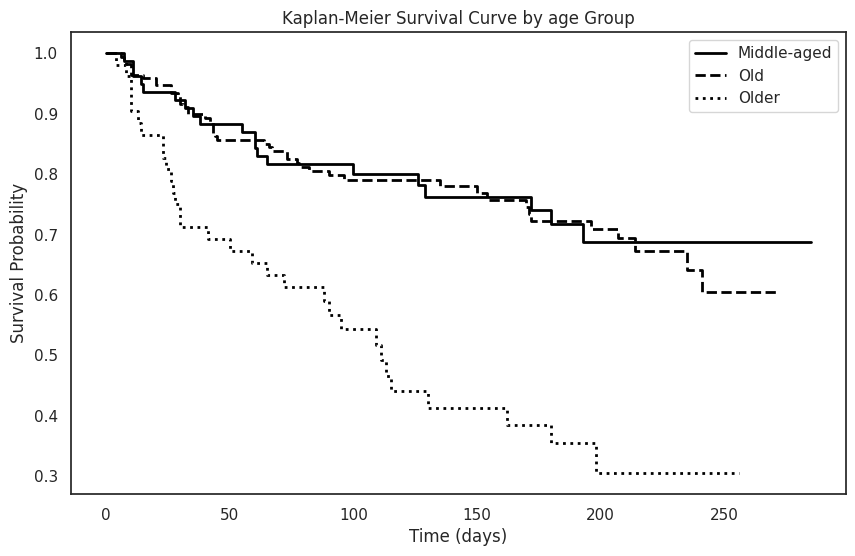

In [ ]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# middle-aged
mask_ma = (data['age_quartile'] == 'middle-aged')
kmf.fit(data[mask_ma]['time'], event_observed=data[mask_ma]['DEATH_EVENT'], label='Middle-aged')
kmf.plot_survival_function(linestyle='-', linewidth=2, color='black', ci_show=False)

# old
mask_old = (data['age_quartile'] == 'old')
kmf.fit(data[mask_old]['time'], event_observed=data[mask_old]['DEATH_EVENT'], label='Old')
kmf.plot_survival_function(linestyle='--', linewidth=2, color='black', ci_show=False)

# very old
mask_veryold = (data['age_quartile'] == 'very old')
kmf.fit(data[mask_veryold]['time'], event_observed=data[mask_veryold]['DEATH_EVENT'], label='Older')
kmf.plot_survival_function(linestyle=':', linewidth=2, color='black', ci_show=False)

plt.title('Kaplan-Meier Survival Curve by age Group')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

# 3) **Indentifiying Foreteeling Factors of Mortality Risk**


Logit model


In [ ]:
# model logit "naïf"
y = data['DEATH_EVENT'] # dependent variable
regressors = data.drop(columns=['DEATH_EVENT','time','age_quartile', 'EF_quartile', 'platelets_quartile']) # explanatory variables (we drop the variables we created)
logit_model=sm.Logit(y,regressors) # logit model
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.494111
         Iterations 6
                             Results: Logit
Model:                 Logit              Method:             MLE       
Dependent Variable:    DEATH_EVENT        Pseudo R-squared:   0.213     
Date:                  2024-11-08 19:21   AIC:                317.4783  
No. Observations:      299                BIC:                358.1832  
Df Model:              10                 Log-Likelihood:     -147.74   
Df Residuals:          288                LL-Null:            -187.67   
Converged:             1.0000             LLR p-value:        5.3226e-13
No. Iterations:        6.0000             Scale:              1.0000    
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
age                       0.0575   0.0130  4.4173 0

In [ ]:
AME = result.get_margeff() # get the marginal effects (for interpretation)
print(AME.summary())

        Logit Marginal Effects       
Dep. Variable:            DEATH_EVENT
Method:                          dydx
At:                           overall
                              dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
age                          0.0094      0.002      5.000      0.000       0.006       0.013
anaemia                      0.0646      0.048      1.335      0.182      -0.030       0.159
creatinine_phosphokinase  4.601e-05   2.27e-05      2.024      0.043    1.46e-06    9.05e-05
diabetes                     0.0321      0.048      0.671      0.502      -0.062       0.126
ejection_fraction           -0.0116      0.002     -5.492      0.000      -0.016      -0.007
high_blood_pressure          0.0706      0.049      1.432      0.152      -0.026       0.167
platelets                -1.082e-07   2.62e-07     -0.413      0.679   -6.21e-07    4.05e-07
serum_creat

- Cox regression

In [ ]:
from lifelines import CoxPHFitter

model_data = data.drop(columns=['age_quartile', 'EF_quartile', 'platelets_quartile'])

# fit the Cox proportional hazards model
cph = CoxPHFitter()
cph.fit(model_data, duration_col='time', event_col='DEATH_EVENT')
cph.print_summary()

latex_table = cph.summary.to_latex(index=True, float_format="%.2f")
print(latex_table)

<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -468.23
         time fit was run = 2024-11-08 19:22:02 UTC

---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                 
age                       0.05      1.05      0.01            0.03            0.06                1.03                1.07
anaemia                   0.46      1.59      0.22            0.04            0.89                1.04                2.42
creatinine_phosphokinase  0.00      1.00      0.00            0.00            0.00                1.00                1.00
diabetes                  0.14      1.15      0.22           -0.30            0.58                0.74                1.78
ejection_fraction        -0.05      0.95      0.01           -0.07           -0.03                0.93                0.97
high_blood_pressure       0.48      1.61      0.22            0.05            0.90                1.05                2.46
platelets                -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
serum_creatinine          0.32      1.38      0.07            0.18            0.46                1.20                1.58
serum_sodium             -0.04      0.96      0.02           -0.09            0.00                0.91                1.00
sex                      -0.24      0.79      0.25           -0.73            0.26                0.48                1.29
smoking                   0.13      1.14      0.25           -0.36            0.62                0.70                1.86

                          cmp to     z      p  -log2(p)
covariate                                              
age                         0.00  4.98 <0.005     20.56
anaemia                     0.00  2.12   0.03      4.90
creatinine_phosphokinase    0.00  2.22   0.03      5.26
diabetes                    0.00  0.63   0.53      0.92
ejection_fraction           0.00 -4.67 <0.005     18.36
high_blood_pressure         0.00  2.20   0.03      5.17
platelets                   0.00 -0.41   0.68      0.55
serum_creatinine            0.00  4.57 <0.005     17.68
serum_sodium                0.00 -1.90   0.06      4.12
sex                         0.00 -0.94   0.35      1.53
smoking                     0.00  0.51   0.61      0.72
---
Concordance = 0.74
Partial AIC = 958.46
log-likelihood ratio test = 81.95 on 11 df
-log2(p) of ll-ratio test = 40.56

\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & coef & exp(coef) & se(coef) & coef lower 95% & coef upper 95% & exp(coef) lower 95% & exp(coef) upper 95% & cmp to & z & p & -log2(p) \\
covariate &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
age & 0.05 & 1.05 & 0.01 & 0.03 & 0.06 & 1.03 & 1.07 & 0.00 & 4.98 & 0.00 & 20.56 \\
anaemia & 0.46 & 1.59 & 0.22 & 0.04 & 0.89 & 1.04 & 2.42 & 0.00 & 2.12 & 0.03 & 4.90 \\
creatinine_phosphokinase & 0.00 & 1.00 & 0.00 & 0.00 & 0.00 & 1.00 & 1.00 & 0.00 & 2.22 & 0.03 & 5.26 \\
diabetes & 0.14 & 1.15 & 0.22 & -0.30 & 0.58 & 0.74 & 1.78 & 0.00 & 0.63 & 0.53 & 0.92 \\
ejection_fraction & -0.05 & 0.95 & 0.01 & -0.07 & -0.03 & 0.93 & 0.97 & 0.00 & -4.67 & 0.00 & 18.36 \\
high_blood_pressure & 0.48 & 1.61 & 0.22 & 0.05 & 0.90 & 1.05 & 2.46 & 0.00 & 2.20 & 0.03 & 5.17 \\
platelets & -0.00 & 1.00 & 0.00 & -0.00 & 0.00 & 1.00 & 1.00 & 0.00 & -0.41 & 0.68 & 0.55 \\
serum_creatinine & 0.32 & 1.38 & 0.07 & 0.18 & 0.46 & 1.20 & 1.58 & 0.00 & 4.57 & 0.00 & 17.68 \\
seru

# 4) **Predicting Death using Machine Learning**


## a. K-nearest neighbors

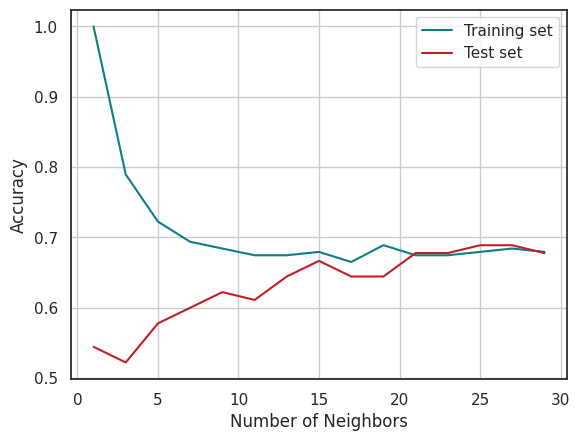

In [ ]:
Y = data['DEATH_EVENT'] # the category we want to predict
X = data.drop(columns=['DEATH_EVENT','age_quartile', 'EF_quartile', 'platelets_quartile'], axis=1) # we drop the variables we created
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
X, Y, test_size=0.3, random_state = 0, stratify = Y) # creates a training and a test set from the dataset and enable “reproducible randomness”

knns = range(1, 31, 2) #for all odd values of k between 1 and 31
acc_learn = [0 for k in knns] # accuracy on the learning set
acc_test = [0 for k in knns] # accuracy on the testing set
for k_idx in range(len(knns)):
      knns_algo = neighbors.KNeighborsClassifier(knns[k_idx]) # KNN model, classification
      knns_algo.fit(X_train, Y_train)
      acc_learn[k_idx] = metrics.accuracy_score(Y_train,
                                                knns_algo.predict(X_train))
      acc_test[k_idx] = metrics.accuracy_score(Y_test,
knns_algo.predict(X_test))

plt.plot(knns, acc_learn, color = "#0d7d87", label="Training set")
plt.plot(knns, acc_test, color = "#c31e23", label="Test set")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig('knn_acc.png', bbox_inches='tight')
plt.show()

In [ ]:
# find the best K
def knn_train_test(X_train, X_test, Y_train, Y_test):
  knns = range(1, 31, 2)
  acc_learn = [0 for k in knns]
  acc_test = [0 for k in knns]
  for k_idx in range(len(knns)):
    knns_algo = neighbors.KNeighborsClassifier(knns[k_idx])
    knns_algo.fit(X_train, Y_train)
    acc_learn[k_idx] = metrics.accuracy_score(Y_train,
                                                    knns_algo.predict(X_train))
    acc_test[k_idx] = metrics.accuracy_score(Y_test,
                                           knns_algo.predict(X_test))
  return {'knns': knns, 'learn': acc_learn, 'test': acc_test}


X_learn, X_test, Y_learn, Y_test = model_selection.train_test_split(
X, Y, test_size=0.33, random_state = 1, stratify = Y) # create our test and learning sets
X_train, X_valid, Y_train, Y_valid = model_selection.train_test_split(
      X_learn, Y_learn, test_size=0.5, random_state = 42, stratify = Y_learn) # create a validation set

results_valid = knn_train_test(X_train, X_valid, Y_train, Y_valid) # on the validation set
best_k = results_valid['knns'][np.array(results_valid['test']).argmax()] # look for the best
print("Best k", best_k, "with validation accuracy", max(results_valid['test']))
best_model = neighbors.KNeighborsClassifier(best_k) # KNN with the best k
best_model.fit(X_learn, Y_learn)
best_acc_test = metrics.accuracy_score(Y_test, best_model.predict(X_test)) # get the accuracy on the test set
print("Accuracy on the test set", best_acc_test)

Best k 15 with validation accuracy 0.68
Accuracy on the test set 0.6666666666666666


## b. Decision Tree

Test set accuracy: 0.69


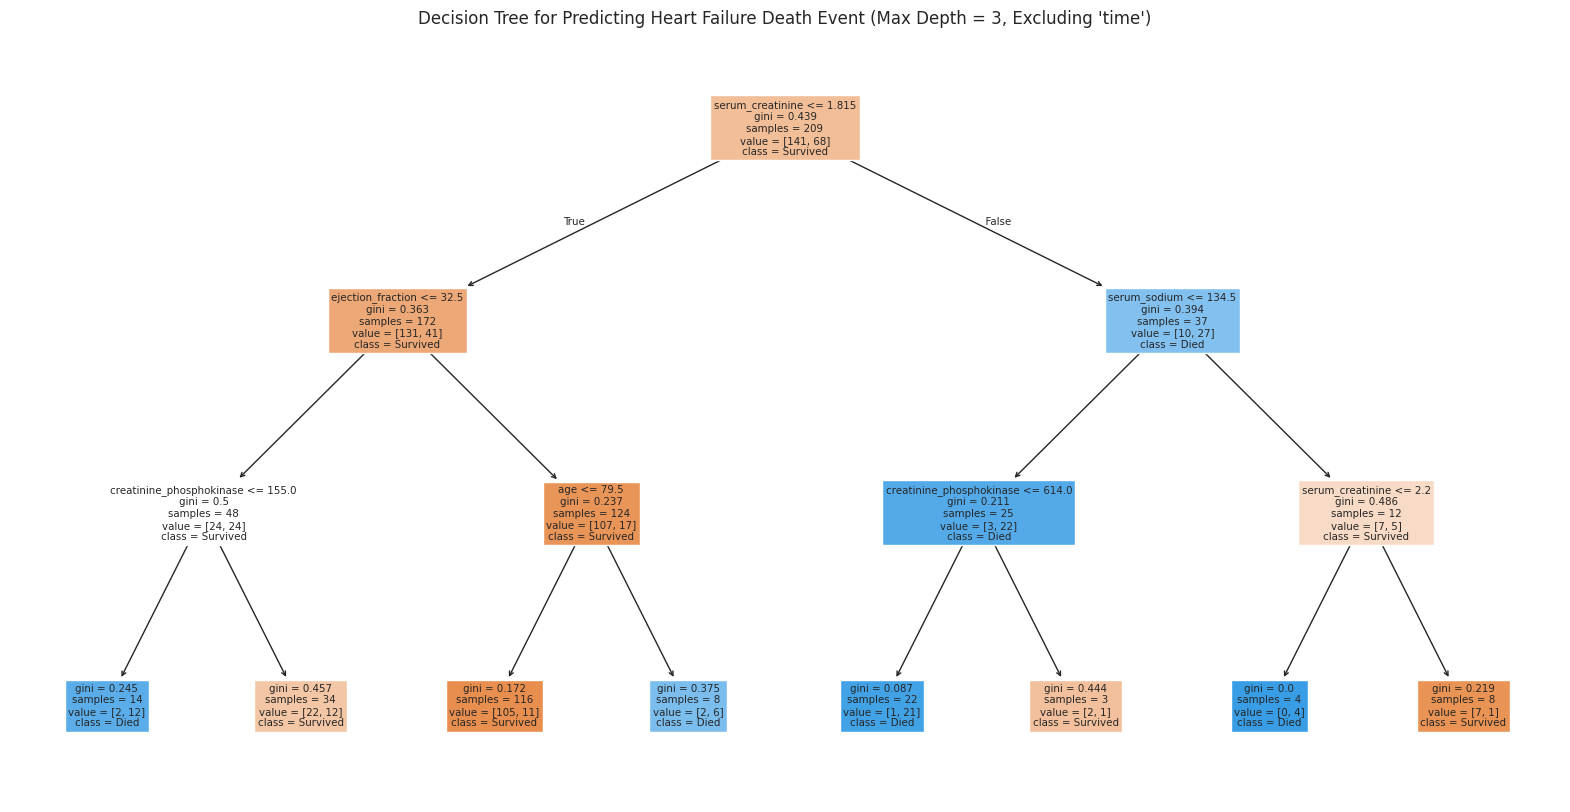

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import tree

X = data.drop(['DEATH_EVENT', 'time','age_quartile', 'EF_quartile', 'platelets_quartile'], axis=1) # Exclude 'time' here, and other variables
Y = data['DEATH_EVENT']

# split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# train a decision tree
dt = DecisionTreeClassifier(random_state=0, max_depth=3)
dt.fit(X_train, Y_train)

# predict
Y_pred = dt.predict(X_test)

# accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Test set accuracy: {accuracy:.2f}")

# plotting the tree
plt.figure(figsize=(20,10))
tree.plot_tree(dt, feature_names=X.columns, class_names=['Survived', 'Died'], filled=True)
plt.title("Decision Tree for Predicting Heart Failure Death Event (Max Depth = 3, Excluding 'time')")
plt.savefig('ML_tree.png', bbox_inches='tight')
plt.show()